<a href="https://colab.research.google.com/github/vruddhis/semanticshift/blob/main/Copy_of_comparing_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers pandas scipy tqdm matplotlib seaborn


In [ ]:
import json
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
from google.colab import files
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
print("Uploaded:", file_path)


Saving test-codalab-10k.data.jl to test-codalab-10k.data.jl
Uploaded: test-codalab-10k.data.jl


In [ ]:
data = []
with open(file_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

df["text1"] = df["tweet1"].apply(lambda x: x["text"])
df["text2"] = df["tweet2"].apply(lambda x: x["text"])
df["date1"] = df["tweet1"].apply(lambda x: x["date"])
df["date2"] = df["tweet2"].apply(lambda x: x["date"])

df = df[["id", "word", "text1", "text2", "date1", "date2"]]


this is a distilled BERT type model fine-tuned for sentence-level semantic similarity tasks

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
tqdm.pandas()

df["emb1"] = df["text1"].progress_apply(lambda x: model.encode(x, show_progress_bar=False))
df["emb2"] = df["text2"].progress_apply(lambda x: model.encode(x, show_progress_bar=False))


100%|██████████| 10000/10000 [05:03<00:00, 32.99it/s]


In [ ]:
df["metric_cosine"] = df.progress_apply(lambda r: cosine(r.emb1, r.emb2), axis=1)



100%|██████████| 10000/10000 [00:00<00:00, 32148.00it/s]


In [ ]:
def months_between(d1, d2):
    try:
        date1 = datetime.strptime(d1, "%Y-%m")
        date2 = datetime.strptime(d2, "%Y-%m")
        return abs((date2.year - date1.year) * 12 + (date2.month - date1.month))
    except:
        return None

df["time_gap"] = df.apply(lambda r: months_between(r["date1"], r["date2"]), axis=1)



In [ ]:
agg = df.groupby("word").agg({"metric_cosine": "mean", "time_gap": "mean"}).reset_index()
agg = agg.sort_values("metric_cosine", ascending=False)
agg.head(10)


,word,metric_cosine,time_gap
13,unlabeled,0.878263,12.0
7,ido,0.817614,12.0
8,launchpad,0.797221,12.0
14,vanguard,0.783215,12.0
3,crt,0.773130,12.0
12,pyre,0.759826,12.0
4,delta,0.753411,12.0
5,gala,0.723180,12.0
10,monet,0.716374,12.0
11,moxie,0.702783,12.0


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy

df["emb1"] = df["emb1"].apply(lambda x: np.array(x))
df["emb2"] = df["emb2"].apply(lambda x: np.array(x))


In [ ]:
from sklearn.neighbors import NearestNeighbors

def neighbor_change(embeddings, k=10):
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(embeddings)
    neighbors = nn.kneighbors(return_distance=False)
    return neighbors


all_embs = np.vstack(df["emb1"].tolist() + df["emb2"].tolist())

neighbors = neighbor_change(all_embs, k=10)

def jaccard_overlap(a, b):
    return len(set(a) & set(b)) / len(set(a) | set(b))

metric_values = []
for i in range(len(df)):
    idx1, idx2 = i, i + len(df)
    overlap = jaccard_overlap(neighbors[idx1], neighbors[idx2])
    metric_values.append(1 - overlap)

df["metric_neighbors"] = metric_values


In [ ]:
from scipy.spatial.distance import cosine
from scipy.stats import entropy

def pseudo_freq_distribution(emb_list, bins=20):
    #dense neighborhood
    sims = cosine_similarity(emb_list)
    sims = sims[np.triu_indices(len(emb_list), k=1)]  # upper triangle only, no self-sim
    hist, _ = np.histogram(sims, bins=bins, range=(-1, 1), density=True)
    hist = hist + 1e-9  #avoid zeros
    hist /= hist.sum()
    return hist

freq_dists = []
for word, group in df.groupby("word"):
    embs1 = np.vstack(group["emb1"].to_list())
    embs2 = np.vstack(group["emb2"].to_list())

    if len(embs1) < 3 or len(embs2) < 3:
        freq_dists.extend([np.nan]*len(group))
        continue

    hist1 = pseudo_freq_distribution(embs1)
    hist2 = pseudo_freq_distribution(embs2)

    kl = entropy(hist1, hist2)
    freq_dists.extend([kl]*len(group))

df["metric_freqdiv"] = freq_dists


In [ ]:
import numpy as np


df["metric_euclidean"] = df.apply(
    lambda row: np.linalg.norm(row["emb1"] - row["emb2"]) if row["emb1"] is not None and row["emb2"] is not None else np.nan,
    axis=1
)


In [ ]:
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

def neighbor_rank_correlation(emb1, emb2, all_embs, top_k=20):
    if emb1 is None or emb2 is None:
        return np.nan
    sims1 = cosine_similarity([emb1], all_embs)[0]
    sims2 = cosine_similarity([emb2], all_embs)[0]
    ranks1 = np.argsort(-sims1)[:top_k]
    ranks2 = np.argsort(-sims2)[:top_k]
    #Spearman correlation of similarity ranks
    corr, _ = spearmanr(sims1[ranks1], sims2[ranks2])
    return corr

all_embeddings = np.vstack(df["emb1"].tolist() + df["emb2"].tolist())

df["metric_rankcorr"] = df.apply(
    lambda row: neighbor_rank_correlation(row["emb1"], row["emb2"], all_embeddings),
    axis=1
)


In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import jensenshannon

def jsd_sense_divergence(emb1, emb2, n_clusters=5):
    X = np.vstack([emb1, emb2]) if emb1.ndim == 2 else np.vstack([emb1.reshape(1,-1), emb2.reshape(1,-1)])
    km = KMeans(n_clusters=min(n_clusters, len(X)), n_init=10, random_state=42)
    labels = km.fit_predict(X)

    p = np.bincount(labels[:len(emb1)]) / len(emb1)
    q = np.bincount(labels[len(emb1):]) / len(emb2)

    m = max(len(p), len(q))
    p = np.pad(p, (0, m-len(p)))
    q = np.pad(q, (0, m-len(q)))

    return jensenshannon(p, q)

df["metric_jsdiv"] = df.apply(
    lambda row: jsd_sense_divergence(np.array([row["emb1"]]), np.array([row["emb2"]])),
    axis=1
)


In [ ]:
df.describe()


,metric_cosine,time_gap,metric_neighbors,metric_freqdiv,metric_rankcorr,metric_euclidean,metric_jsdiv
count,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,0.715023,12.0,0.996976,0.228501,0.973283,1.188774,8.325546e-01
std,0.151302,0.0,0.026118,0.207346,0.030734,0.129864,1.647653e-13
min,0.053539,12.0,0.333333,0.018094,0.854436,0.327227,8.325546e-01
25%,0.603576,12.0,1.000000,0.103478,0.956049,1.098704,8.325546e-01
50%,0.720967,12.0,1.000000,0.154767,0.991241,1.200805,8.325546e-01
75%,0.831173,12.0,1.000000,0.367345,1.000000,1.289320,8.325546e-01
max,1.136250,12.0,1.000000,0.763253,1.000000,1.507481,8.325546e-01


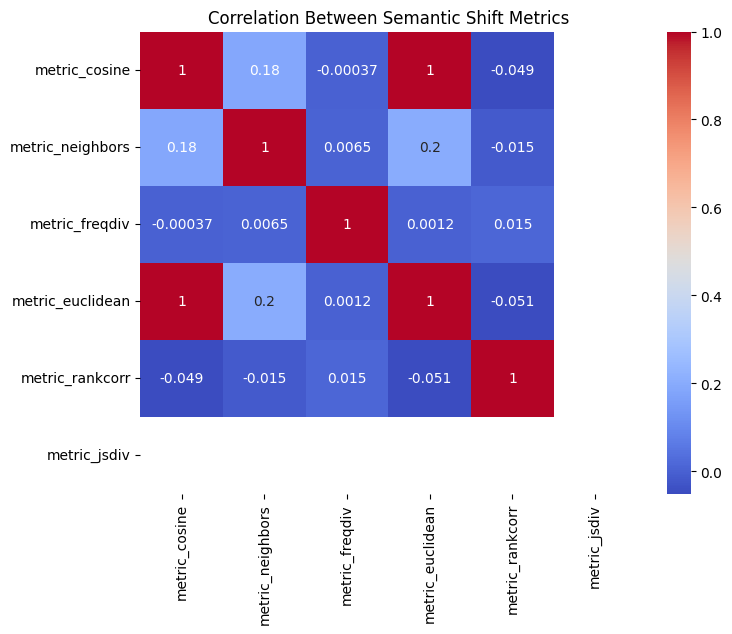

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

metrics = [
    "metric_cosine",
    "metric_neighbors",
    "metric_freqdiv",
    "metric_euclidean",
    "metric_rankcorr",
    "metric_jsdiv"
]


numeric_metrics = [m for m in metrics if m in df.columns and np.issubdtype(df[m].dtype, np.number)]

df_metrics = df[numeric_metrics].dropna()

df_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_metrics), columns=numeric_metrics)

corr = df_norm.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Semantic Shift Metrics")
plt.show()


In [ ]:
df.groupby("word")[["metric_cosine", "metric_neighbors", "metric_freqdiv", "metric_euclidean", "metric_rankcorr"]].mean().sort_values("metric_cosine", ascending=False).head(10)


,metric_cosine,metric_neighbors,metric_freqdiv,metric_euclidean,metric_rankcorr
word,,,,,
unlabeled,0.878263,0.998205,0.230476,1.322388,0.970039
ido,0.817614,0.997779,0.215112,1.275154,0.973424
launchpad,0.797221,0.998701,0.221367,1.259524,0.977006
vanguard,0.783215,0.995707,0.228203,1.247440,0.956564
crt,0.773130,0.996440,0.233409,1.238698,0.974158
pyre,0.759826,0.996047,0.238525,1.228847,0.967581
delta,0.753411,0.998515,0.217486,1.223598,0.975049
gala,0.723180,0.995547,0.235222,1.198373,0.970219
monet,0.716374,0.996518,0.227881,1.192800,0.979469


In [ ]:
display(df)

,id,word,text1,text2,date1,date2,emb1,emb2,metric_cosine,time_gap,metric_neighbors,metric_freqdiv,metric_rankcorr,metric_euclidean,metric_jsdiv
0,d50976a4,milker,my fan base is now called milkers ❤️,i got too many ocs with big mommy milkers... w...,2020-03,2021-03,"[-0.015597368, -0.14415821, 0.04479774, -0.003...","[0.022923982, -0.08162973, -0.018275885, 0.010...",0.713851,12,1.0,0.154767,0.928817,1.194865,0.832555
1,f7b09ad3,unlabeled,the world of digital art brought to a standsti...,they completely disrespected that is unlabeled.,2020-03,2021-03,"[-0.059141193, -0.0046784566, 0.01713829, -0.0...","[0.011953324, 0.044951938, -0.03854711, -0.021...",0.842203,12,1.0,0.154767,0.931530,1.297847,0.832555
2,d7f5ca24,vanguard,Every day more stories on corruption. A rear v...,Sorry for the inactivity shots been crazy at t...,2020-09,2021-09,"[0.050099473, 0.020287888, 0.00048627716, 0.00...","[-0.031883534, -0.08215091, 0.014643873, -0.10...",0.907380,12,1.0,0.154767,1.000000,1.347130,0.832555
3,3f2da747,milker,permission to resume chatter about thy teats n...,mommy milkers in the tub,2020-03,2021-03,"[-0.08795118, -0.063893355, 0.0028110023, -0.0...","[-0.012278275, -0.0704047, 0.042699978, 0.0175...",0.631997,12,1.0,0.154767,1.000000,1.124275,0.832555
4,2917d80c,bullpen,Hitters: you should be getting some type of hi...,This game is solely on Rojas. You had an off d...,2020-06,2021-06,"[0.036415294, 0.014076551, -0.020312196, 0.011...","[0.058363352, 0.008793727, -0.04373466, 0.0538...",0.542977,12,1.0,0.154767,0.958562,1.042092,0.832555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1bcbea65,vanguard,i'll never forgive drake for using rihanna's v...,We're rocking out at the vanguard today,2020-09,2021-09,"[0.023058694, 0.024232192, 0.06618813, -0.0339...","[0.021892816, 0.00707017, -0.025124326, -0.040...",0.946364,12,1.0,0.367345,0.899258,1.375765,0.832555
9996,279a7f5a,crt,This pendamic is wrecking havoc in maintenance...,military being used political for the left aga...,2020-06,2021-06,"[-0.10538022, 0.0493082, 0.09045393, -0.035366...","[-0.008576149, -0.019668577, 0.046767045, -0.0...",0.894120,12,1.0,0.367345,1.000000,1.337251,0.832555
9997,c2751b70,pyre,This I don't think is a hot take but the endin...,"heavy rain turns any funeral pyre to mud, in t...",2020-04,2021-04,"[-0.03554694, -0.06554562, 0.069382675, -0.040...","[-0.027054958, 0.050105616, 0.14793609, -0.021...",0.874127,12,1.0,0.367345,0.964009,1.322215,0.832555
9998,a5b8d2d9,ido,"help guys, so my friend's sis organized a pool...",profesora: ustedes que han ido a California sa...,2020-05,2021-05,"[0.018598175, 0.029088266, -0.02094674, -0.041...","[-0.021798516, 0.017491842, -0.0078088245, 0.0...",1.010519,12,1.0,0.367345,1.000000,1.421632,0.832555
